# Performance of Roshambo network
### Comparing ANN, NHP, and SNN (with frames-, Poisson-, and DVS-input)

In [1]:
% matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

## Parameters

In [3]:
path_wd = '/home/rbodo/.snntoolbox/data/roshambo'
log_dir = os.path.join(path_wd, 'log')

num_frames_to_test = 15850
num_dvs_sequences_to_test = 4
batch_size_frames = 50
batch_size_dvs = 20
duration_frames = 30
duration_dvs = 100
dt = 1
poisson_input_rate = 1000
T = int(duration_frames / dt)
L = 10  # num layers, excluding output layer.
scale = 1e6  # Unit: Million operations

## Load spike counts and compute statistics

In [4]:
# For frame input:
s = np.empty((num_frames_to_test, L, T))
for batch_idx in range(int(num_frames_to_test / batch_size_frames)):
    # Insert batch of layer-spikecounts over time, shape (batch, L, T)
    s[batch_idx*batch_size_frames: (batch_idx+1)*batch_size_frames] = \
        np.load(os.path.join(path_wd, 'log', 'gui', '01', 'spikecounts', str(batch_idx) + '_l.npz'))['layer_spike_counts'][:, :-1, :]
s_samplemean = np.mean(s, axis=0)  # Averaged across samples, shape (L, T)
s_samplestd = np.std(s, axis=0)  # Samples contribute main part of variation. Activity in layers is fairly similar. 
s_layermean = np.mean(s, axis=1)  # Averaged across layers, shape (num_samples, T)
s_layerstd = np.std(s, axis=1)
s_mean = np.mean(s, axis=(0, 1))
s_std = np.std(s, axis=(0, 1))

# For Poisson input:
s_poisson = np.empty((num_frames_to_test, L, T))
for batch_idx in range(int(num_frames_to_test / batch_size_frames)):
    # Insert batch of layer-spikecounts over time, shape (batch, L, T)
    s_poisson[batch_idx*batch_size_frames: (batch_idx+1)*batch_size_frames] = \
        np.load(os.path.join(path_wd, 'log', 'gui', '04', 'spikecounts', str(batch_idx) + '_l.npz'))['layer_spike_counts'][:, :-1, :]
s_samplemean_poisson = np.mean(s_poisson, axis=0)  # Averaged across samples, shape (L, T)
s_samplestd_poisson = np.std(s_poisson, axis=0)  # Samples contribute main part of variation. Activity in layers is fairly similar. 
s_layermean_poisson = np.mean(s_poisson, axis=1)  # Averaged across layers, shape (num_samples, T)
s_layerstd_poisson = np.std(s_poisson, axis=1)
s_mean_poisson = np.mean(s_poisson, axis=(0, 1))
s_std_poisson = np.std(s_poisson, axis=(0, 1))

# For Poisson input with 2000 events:
s_poisson_short = np.empty((15000, L, 150))
for batch_idx in range(int(15000 / batch_size_frames)):
    # Insert batch of layer-spikecounts over time, shape (batch, L, T)
    s_poisson_short[batch_idx*batch_size_frames: (batch_idx+1)*batch_size_frames] = \
        np.load(os.path.join(path_wd, 'log', 'gui', '16', 'spikecounts', str(batch_idx) + '_l.npz'))['layer_spike_counts'][:, :-1, :]
s_samplemean_poisson_short = np.mean(s_poisson_short, axis=0)  # Averaged across samples, shape (L, T)
s_samplestd_poisson_short = np.std(s_poisson_short, axis=0)  # Samples contribute main part of variation. Activity in layers is fairly similar. 
s_layermean_poisson_short = np.mean(s_poisson_short, axis=1)  # Averaged across layers, shape (num_samples, T)
s_layerstd_poisson_short = np.std(s_poisson_short, axis=1)
s_mean_poisson_short = np.mean(s_poisson_short, axis=(0, 1))
s_std_poisson_short = np.std(s_poisson_short, axis=(0, 1))

# For DVS input:
s_dvs = []
for batch_idx in range(0, 129):  # range(num_dvs_sequences_to_test):
    # Insert batch of layer-spikecounts over time, shape (batch, L, T)
    s_dvs.append(np.load(os.path.join(path_wd, 'log', 'gui', '13', 'spikecounts', str(batch_idx) + '_l.npz'))['layer_spike_counts'][:, :-1, :])
s_dvs = np.concatenate(s_dvs)
s_samplemean_dvs = np.mean(s_dvs, axis=0)  # Averaged across samples, shape (L, T)
s_samplestd_dvs = np.std(s_dvs, axis=0)  # Samples contribute main part of variation. Activity in layers is fairly similar. 
s_layermean_dvs = np.mean(s_dvs, axis=1)  # Averaged across layers, shape (num_samples, T)
s_layerstd_dvs = np.std(s_dvs, axis=1)
s_mean_dvs = np.mean(s_dvs, axis=(0, 1))
s_std_dvs = np.std(s_dvs, axis=(0, 1))

n = np.array([16*60*60, 16*30*30, 32*28*28, 32*14*14, 64*12*12, 64*6*6, 128*4*4, 128*2*2, 128*2*2, 128*1*1, 4])  # Number of neurons per layer
fin = np.array([1*5*5, 0, 16*3*3, 0, 32*3*3, 0, 64*3*3, 0, 128*1*1, 0, 128])  # fan-in per layer: num_input_channels * kernel_x * kernel_y. Pooling layers are not counted.
fout = np.array([1, 32*3*3, 1, 64*3*3, 1, 128*3*3, 1, 128*1*1, 1, 4])  # fan-out per layer. MaxPooling costs one addition per spike to estimate the firing rates.

## Compute number of input spikes when using Poisson spike trains

In [10]:
num_input_neurons = 1*64*64  # num_channels*num_rows*num_cols
mean_input_activation = 0.075524298931175432  # mean(x_test)
std_input_activation = 0.20820052626306976  # std(x_test)
firing_prob = poisson_input_rate / 1000  # == 1
mean_input_rate = num_input_neurons * mean_input_activation * firing_prob
std_input_rate = num_input_neurons * std_input_activation * firing_prob
mean_input_rate_short = 10  # In second Poisson experiment, limit input rate to 10
std_input_rate_short = num_input_neurons * std_input_activation * 0.1
sin_t = [(t+1) * mean_input_rate for t in range(T)]  # Input spikes vs time
sin_t_short = [(t+1) * mean_input_rate_short for t in range(150)]
sout_t = s_samplemean[-1]  # Output spikes vs time

## Performance of ANN and NHP

In [5]:
# Error and number of operations in standard ANN
err_ANN = 0.1
c_ANN = np.dot(n, fin) * 2 / scale  # Double to get number of operations from MACs

# Error and number of operations in ANN on NullHop accelerator
sparsity = 0.52
uncertainty = 0.05
err_NHP = 0.1
c_NHP = c_ANN * sparsity
std_c_NHP = c_NHP * uncertainty

## Spike statistics of DVS samples

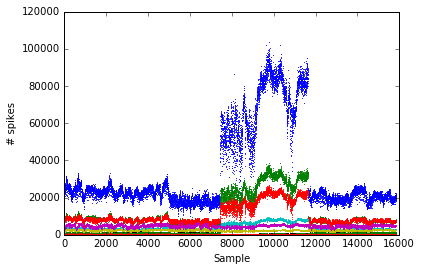

In [9]:
plt.plot(s[:, :, -1], '.', markersize=1)
plt.xlabel('Sample')
plt.ylabel('# spikes')
plt.savefig(os.path.join(log_dir, 'spikes_vs_sample'), bbox_inches='tight')

The high activity occurs in part of the background samples of the data set, where the whole camera is tilted and every pixel is active, instead of just an object in the center.

Class label indices: {'0': 'paper', '1': 'scissors', '2': 'rock', '3': 'background'}


Class boundaries: {'0': 0, '2': 4997, '3': 7435, '1': 11633}

## Compute number of operations

In [11]:
num_computations = np.array([si * fi + fin[0] * n[0] for si, fi in zip(s_samplemean, fout)]) / scale  # Shape (L, T)
num_computations_poisson = np.array([si * fi + 16*5*5*mean_input_rate for si, fi in zip(s_samplemean_poisson, fout)]) / scale
num_computations_poisson_short = np.array([si * fi + 16*5*5*mean_input_rate_short for si, fi in zip(s_samplemean_poisson_short, fout)]) / scale
num_computations_dvs = np.array([si * fi for si, fi in zip(s_samplemean_dvs, fout)]) / scale
num_computations_dvs[0] += fin[0] * n[0] / scale  # Add input impule (only during first time step)

## Plot number of operations vs time

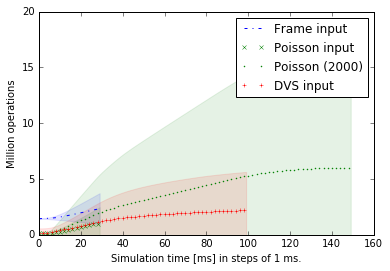

In [22]:
mean_c_t = np.mean(num_computations, axis=0)
std_c_t = np.std(num_computations, axis=0)
mean_c_t_poisson = np.mean(num_computations_poisson, axis=0)
std_c_t_poisson = np.std(num_computations_poisson, axis=0)
mean_c_t_poisson_short = np.mean(num_computations_poisson_short, axis=0)
std_c_t_poisson_short = np.std(num_computations_poisson_short, axis=0)
mean_c_t_dvs = np.mean(num_computations_dvs, axis=0)
std_c_t_dvs = np.std(num_computations_dvs, axis=0)
time = np.arange(0, duration_frames, dt)
time_poisson_short = np.arange(0, 150, dt)
time_dvs = np.arange(0, duration_dvs, dt)
plt.plot(time[::2], mean_c_t[::2], '-.b', markersize=4, label='Frame input')
plt.fill_between(time, mean_c_t-std_c_t, mean_c_t+std_c_t, alpha=0.1, color='blue')
plt.plot(time[::2], mean_c_t_poisson[::2], 'xg', markersize=4, label='Poisson input')
plt.fill_between(time, mean_c_t_poisson-std_c_t_poisson, mean_c_t_poisson+std_c_t_poisson, alpha=0.1, color='green')
plt.plot(time_poisson_short[::2], mean_c_t_poisson_short[::2], '.g', markersize=2, label='Poisson (2000)')
plt.fill_between(time_poisson_short, mean_c_t_poisson_short-std_c_t_poisson_short, mean_c_t_poisson_short+std_c_t_poisson_short, alpha=0.1, color='green')
plt.plot(time_dvs[::2], mean_c_t_dvs[::2], '+r', markersize=4, label='DVS input')
plt.fill_between(time_dvs, mean_c_t_dvs-std_c_t_dvs, mean_c_t_dvs+std_c_t_dvs, alpha=0.1, color='red')
plt.ylabel('Million operations')
plt.xlabel('Simulation time [ms] in steps of {} ms.'.format(dt))
plt.legend()
plt.ylim(0, None)
plt.savefig(os.path.join(log_dir, 'ops_vs_t'), bbox_inches='tight')

The high variance in operation count is due to the fact that background samples have a much higher global activity than the other classes (see Figure above).

## Load error vs time and compute statistics

In [23]:
# Batch-averaged error vs time. Shape (num_batches, T)
error_t = np.multiply(100, np.load(os.path.join(path_wd, 'log', 'gui', '01', 'net_top1err_t.npz'))['net_top1err_t'])
mean_error_t = np.mean(error_t, axis=0)
std_error_t = np.std(error_t, axis=0)

# For Poisson input
error_t_poisson = np.multiply(100, np.load(os.path.join(path_wd, 'log', 'gui', '04', 'net_top1err_t.npz'))['net_top1err_t'])
mean_error_t_poisson = np.mean(error_t_poisson, axis=0)
std_error_t_poisson = np.std(error_t_poisson, axis=0)

# For Poisson input limited to 2000 events
error_t_poisson_short = np.multiply(100, np.load(os.path.join(path_wd, 'log', 'gui', '16', 'net_top1err_t.npz'))['net_top1err_t'])
mean_error_t_poisson_short = np.mean(error_t_poisson_short, axis=0)
std_error_t_poisson_short = np.std(error_t_poisson_short, axis=0)

# For DVS input
error_t_dvs = np.multiply(100, np.load(os.path.join(path_wd, 'log', 'gui', '13', 'net_top1err_t.npz'))['net_top1err_t'])
mean_error_t_dvs = np.mean(error_t_dvs, axis=0)
std_error_t_dvs = np.std(error_t_dvs, axis=0)

## Plot error vs time

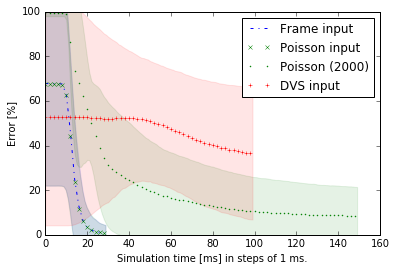

In [27]:
plt.plot(time[::2], mean_error_t[::2], '-.b', markersize=4, label='Frame input')
plt.fill_between(time, mean_error_t-std_error_t, mean_error_t+std_error_t, alpha=0.1, color='blue')
plt.plot(time[::2], mean_error_t_poisson[::2], 'xg', markersize=4, label='Poisson input')
plt.fill_between(time, mean_error_t_poisson-std_error_t_poisson, mean_error_t_poisson+std_error_t_poisson, alpha=0.1, color='green')
plt.plot(time_poisson_short[::2], mean_error_t_poisson_short[::2], '.g', markersize=2, label='Poisson (2000)')
plt.fill_between(time_poisson_short, mean_error_t_poisson_short-std_error_t_poisson_short, mean_error_t_poisson_short+std_error_t_poisson_short, alpha=0.1, color='green')
plt.plot(time_dvs[::2], mean_error_t_dvs[::2], '+r', markersize=4, label='DVS input')
plt.fill_between(time_dvs, mean_error_t_dvs-std_error_t_dvs, mean_error_t_dvs+std_error_t_dvs, alpha=0.1, color='red')
plt.ylabel('Error [%]')
plt.xlabel('Simulation time [ms] in steps of {} ms.'.format(dt))
plt.ylim(0, 100)
#plt.xlim(0, duration_frames)
plt.legend()
plt.savefig(os.path.join(log_dir, 'err_vs_t'), bbox_inches='tight')

## Plot error vs operations

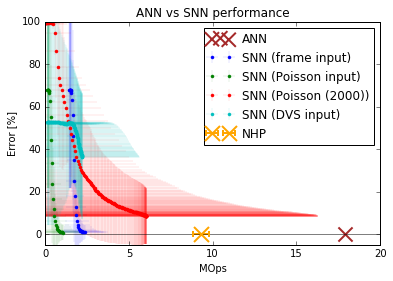

In [28]:
plt.errorbar(mean_c_t, mean_error_t, xerr=std_c_t, yerr=std_error_t, fmt='.', label='SNN (frame input)', capsize=0, elinewidth=0.1)
plt.errorbar(mean_c_t_poisson, mean_error_t_poisson, xerr=std_c_t_poisson, yerr=std_error_t_poisson, fmt='.', label='SNN (Poisson input)',
             capsize=0, elinewidth=0.1)
plt.errorbar(mean_c_t_poisson_short, mean_error_t_poisson_short, xerr=std_c_t_poisson_short, yerr=std_error_t_poisson_short, fmt='.', label='SNN (Poisson (2000))',
             capsize=0, elinewidth=0.1)
plt.errorbar(mean_c_t_dvs, mean_error_t_dvs, xerr=std_c_t_dvs, yerr=std_error_t_dvs, fmt='.', label='SNN (DVS input)', capsize=0, elinewidth=0.1)
plt.scatter(c_ANN, err_ANN, s=200, marker='x', label='ANN', color='brown', linewidths=2)
plt.errorbar(c_NHP, err_NHP, xerr=std_c_NHP, fmt='x', label='NHP', markersize=15, elinewidth=2, capthick=2, markeredgewidth=2, color='orange')
plt.hlines(0, 0, 20, linewidth=0.5)
plt.ylim(-5, 100)
plt.xlim(0, 20)
plt.ylabel('Error [%]')
plt.xlabel('MOps')
plt.legend()
plt.title('ANN vs SNN performance')
plt.savefig(os.path.join(log_dir, 'err_vs_ops'), bbox_inches='tight')

The DVS-curve stops before converging because we only use a limited number of input events (1000) for each trial, so after a while there are simply no more spikes in the network. On the other hand, using more input events has a blurring effect and does not improve classification accuracy.

## Plot output spikes vs input spikes (Poisson)

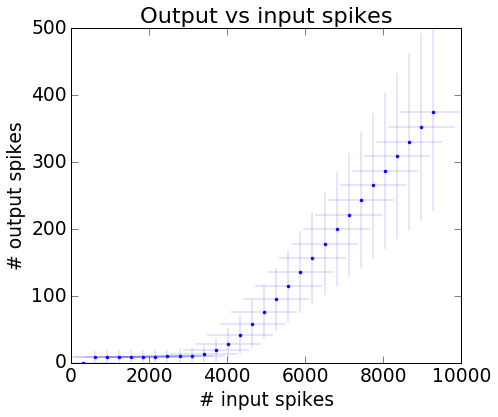

In [14]:
plt.errorbar(sin_t, sout_t, xerr=std_input_rate, yerr=s_samplestd[-1], fmt='.', capsize=0, elinewidth=0.2)
plt.ylabel('# output spikes')
plt.xlabel('# input spikes')
plt.title('Output vs input spikes')
plt.xlim(0, 10000)
plt.ylim(0, 500)
plt.savefig(os.path.join(log_dir, 'spikes_out_vs_in'), bbox_inches='tight')

## Plot error vs input spikes (Poisson)

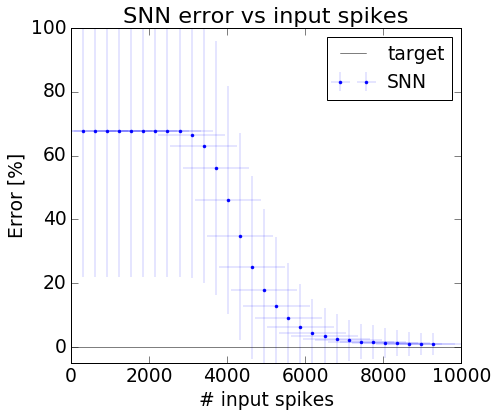

In [15]:
plt.errorbar(sin_t, mean_error_t, xerr=std_input_rate, yerr=std_error_t, fmt='.', capsize=0, elinewidth=0.2, label='SNN')
plt.hlines(0.1, 0, 10000, linewidth=0.5, label='target')
plt.ylim(-5, 100)
plt.xlim(0, 10000)
plt.ylabel('Error [%]')
plt.xlabel('# input spikes')
plt.title('SNN error vs input spikes')
plt.legend()
plt.savefig(os.path.join(log_dir, 'err_vs_inp'), bbox_inches='tight')

When using the DVS input directly, an increase in performance could be achieved by turning off reset between frames.
This has not helped when using frames as input. Reset of the membrane potential to zero after spikes also did not help.

## Plot membrane potential vs time for a single neuron across all layers

In [159]:
log_data = np.load(os.path.join(log_dir, 'gui', '14', 'mem.npz'))
mem_l_t = log_data['mem_l_t']
mem_t = mem_l_t[:10]
mem_t_last = mem_l_t[10:]
spiketimes_l_t = log_data['spikes_l_t']
spikes_l_t = np.array(spiketimes_l_t > 0, 'int32')
inp_t = log_data['inp_t']

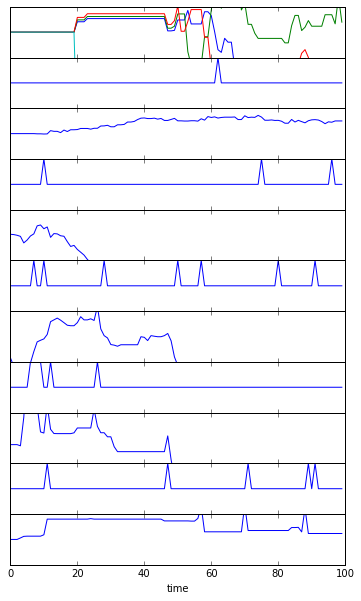

In [162]:
f, ax = plt.subplots(11, 1, sharex=True, sharey=True)
f.set_figheight(10)
for mem_last in mem_t_last:
    ax[0].plot(mem_last)
for i, mem in enumerate(mem_t):
    ax[10-i].plot(mem + spikes_l_t[i])
    ax[10-i].set_ylim(-1, 1)
    ax[10-i].set_yticks([])
ax[-1].plot(inp_t.nonzero()[0], np.zeros(np.count_nonzero(inp_t)), '|', markersize=20)
ax[-1].set_xlabel('Simulation time')
ax[0].set_ylim(-1, 1)
#ax[0].set_ylabel('V_mem')
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(os.path.join(log_dir, 'mem_l_t'), bbox_inches='tight')

## Compare first layer dynamics using Poisson vs DVS input

In [82]:
T2 = 250
num_neurons_input = 64*64
num_neurons_first = 60*60
path_dvs = os.path.join(path_wd, 'log', 'gui', '18')
path_poisson = os.path.join(path_wd, 'log', 'gui', '19')
# Load spiketrains of first layer, for second sample in batch.
spiketrains_dvs = np.load(os.path.join(path_dvs, 'spiketrains', '0.npz'))['spiketrains'][0][0][1]  # Shape (16, 60, 60, 250)
spiketrains_poisson = np.load(os.path.join(path_poisson, 'spiketrains', '0.npz'))['spiketrains'][0][0][1]
# Load input frames of each time step, for second sample in batch.
input_t_dvs = np.load(os.path.join(path_dvs, 'input_t', '0.npz'))['input_t'][:, 1, 0]  # Shape (250, 64, 64)
input_t_poisson = np.load(os.path.join(path_poisson, 'input_t', '0.npz'))['input_t'][:, 1, 0]

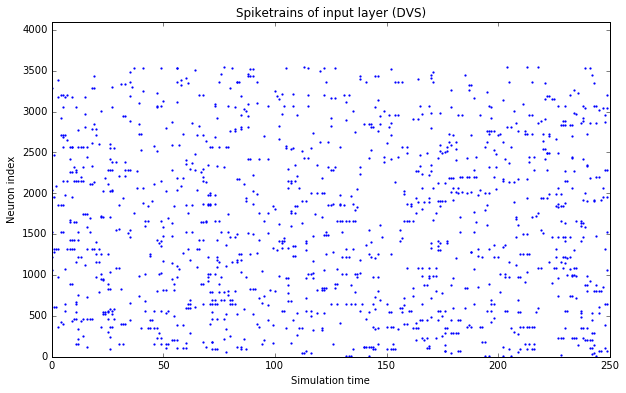

In [200]:
plt.figure(figsize=(10, 6))
plt.xlabel('Simulation time')
plt.title('Spiketrains of input layer (DVS)')
plt.ylabel('Neuron index')
nz = np.reshape(input_t_dvs, (-1, T2)).nonzero()
plt.scatter(nz[1], nz[0], s=5, linewidths=0, color='b')
plt.xlim(0, T2)
plt.ylim(0, num_neurons_input)
plt.savefig(os.path.join(log_dir, 'input_t_dvs'), bbox_inches='tight')

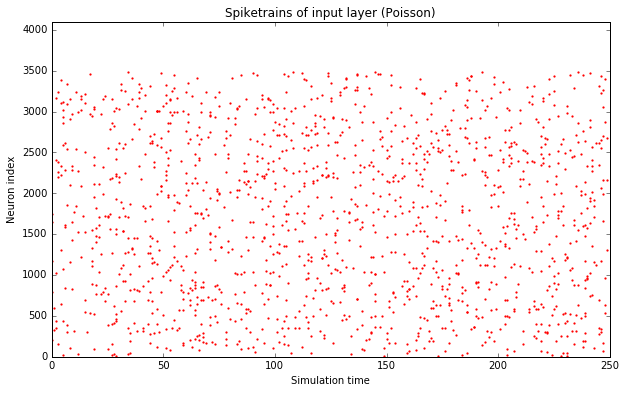

In [201]:
plt.figure(figsize=(10, 6))
plt.xlabel('Simulation time')
plt.title('Spiketrains of input layer (Poisson)')
plt.ylabel('Neuron index')
nz = np.reshape(input_t_poisson, (-1, T2)).nonzero()
plt.scatter(nz[1], nz[0], s=5, linewidths=0, color='r')
plt.xlim(0, T2)
plt.ylim(0, num_neurons_input)
plt.savefig(os.path.join(log_dir, 'input_t_poisson'), bbox_inches='tight')

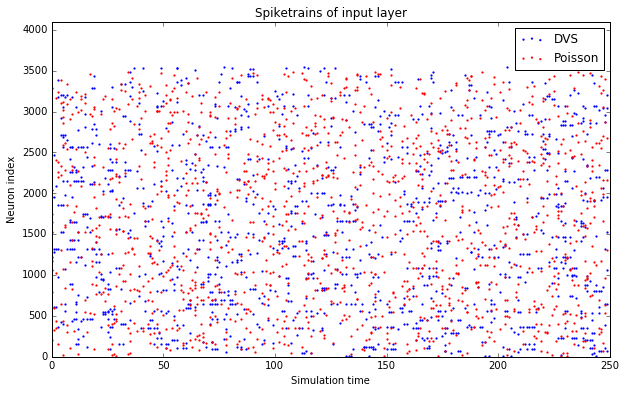

In [202]:
plt.figure(figsize=(10, 6))
plt.xlabel('Simulation time')
plt.title('Spiketrains of input layer')
plt.ylabel('Neuron index')
nz_dvs = np.reshape(input_t_dvs, (-1, T2)).nonzero()
nz_poisson = np.reshape(input_t_poisson, (-1, T2)).nonzero()
plt.scatter(nz_dvs[1], nz_dvs[0], s=5, linewidths=0, color='b', label='DVS')
plt.scatter(nz_poisson[1], nz_poisson[0], s=5, linewidths=0, color='r', label='Poisson')
plt.xlim(0, T2)
plt.ylim(0, num_neurons_input)
plt.legend()
plt.savefig(os.path.join(log_dir, 'input_t_dvs_poisson'), bbox_inches='tight')

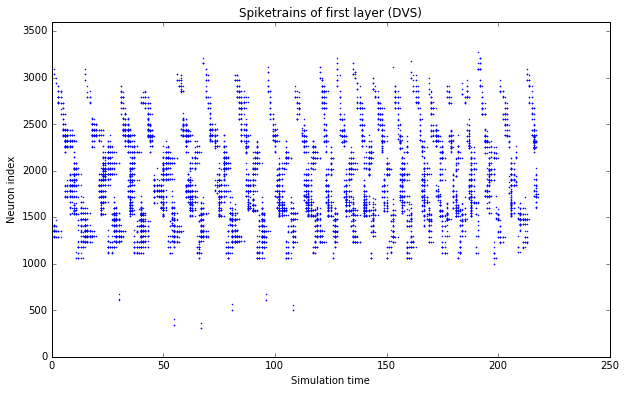

In [203]:
plt.figure(figsize=(10, 6))
plt.xlabel('Simulation time')
plt.title('Spiketrains of first layer (DVS)')
plt.ylabel('Neuron index')
plt.xlim(0, T2)
plt.ylim(0, num_neurons_first)

for (neuron, spiketrain) in enumerate(np.reshape(spiketrains_dvs[2], (-1, T2))):
    spikelist = [j for j in spiketrain if j != 0]
    y = np.ones_like(spikelist) * neuron
    plt.plot(spikelist, y, '.', markersize=2, color='b')

plt.savefig(os.path.join(log_dir, 'firstlayer_t_dvs'), bbox_inches='tight')

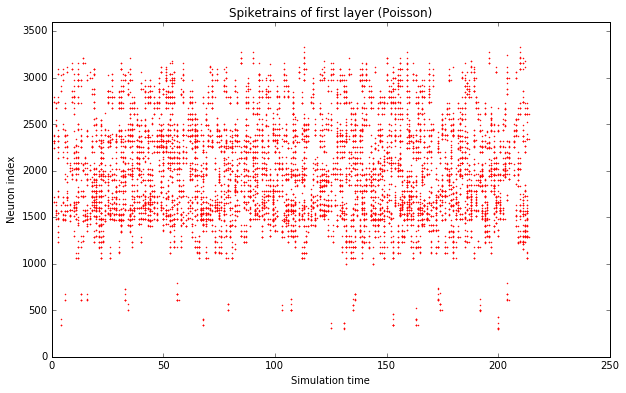

In [204]:
plt.figure(figsize=(10, 6))
plt.xlabel('Simulation time')
plt.title('Spiketrains of first layer (Poisson)')
plt.ylabel('Neuron index')
plt.xlim(0, T2)
plt.ylim(0, num_neurons_first)

for (neuron, spiketrain) in enumerate(np.reshape(spiketrains_poisson[2], (-1, T2))):
    spikelist = [j for j in spiketrain if j != 0]
    y = np.ones_like(spikelist) * neuron
    plt.plot(spikelist, y, '.', markersize=2, color='r')

plt.savefig(os.path.join(log_dir, 'firstlayer_t_poisson'), bbox_inches='tight')

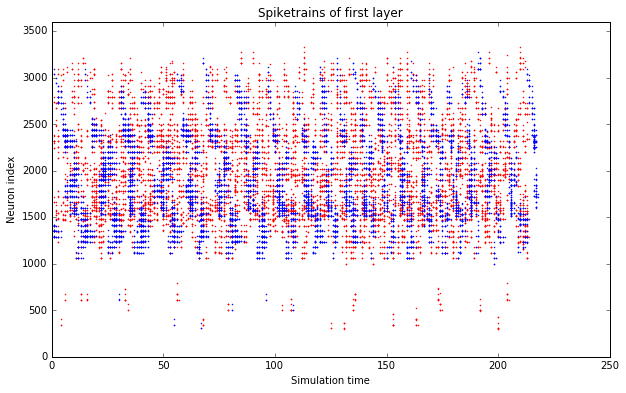

In [207]:
plt.figure(figsize=(10, 6))
plt.xlabel('Simulation time')
plt.title('Spiketrains of first layer')
plt.ylabel('Neuron index')
plt.xlim(0, T2)
plt.ylim(0, num_neurons_first)

for (neuron, spiketrain) in enumerate(np.reshape(spiketrains_poisson[2], (-1, T2))):
    spikelist = [j for j in spiketrain if j != 0]
    y = np.ones_like(spikelist) * neuron
    plt.plot(spikelist, y, '.', markersize=2, color='r')

for (neuron, spiketrain) in enumerate(np.reshape(spiketrains_dvs[2], (-1, T2))):
    spikelist = [j for j in spiketrain if j != 0]
    y = np.ones_like(spikelist) * neuron
    plt.plot(spikelist, y, '.', markersize=2, color='b')


plt.savefig(os.path.join(log_dir, 'firstlayer_t_dvs_poisson'), bbox_inches='tight')

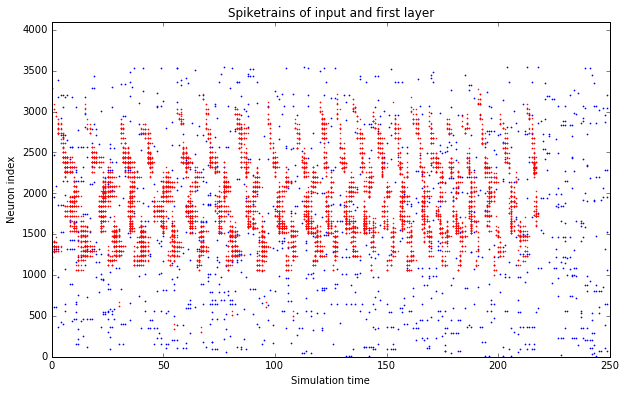

In [104]:
plt.figure(figsize=(10, 6))
plt.xlabel('Simulation time')
plt.title('Spiketrains of input and first layer')
plt.ylabel('Neuron index')
plt.xlim(0, T2)
plt.ylim(0, num_neurons_input)

nz = np.reshape(input_t_dvs, (-1, T2)).nonzero()
plt.scatter(nz[1], nz[0], s=3, linewidths=0, color='b', label='Input layer')

for (neuron, spiketrain) in enumerate(np.reshape(spiketrains_dvs[2], (-1, T2))):
    spikelist = [j for j in spiketrain if j != 0]
    y = np.ones_like(spikelist) * neuron
    plt.plot(spikelist, y, '.', markersize=2, color='r', label='First layer')

In [156]:
in_flat = np.reshape(input_t_dvs, (-1, T2)) * np.arange(T2)
ifr = np.zeros_like(in_flat, 'float32')
for i, n in enumerate(in_flat):
    i_nonzero = 0
    for t in range(T2):
        if n[t]:
            ifr[i, t] = 1 / (n[t] - i_nonzero)
            i_nonzero = n[t]
max_ifr = np.argmax(ifr, axis=0)

ss = np.reshape(spiketrains_dvs[2], (-1, T2))
med_first_t = [np.median(ss[:, t].nonzero()) for t in range(T2)]

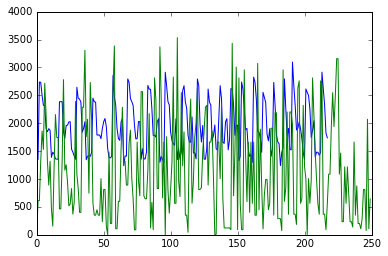

In [183]:
plt.plot(med_first_t)
plt.plot(max_ifr)

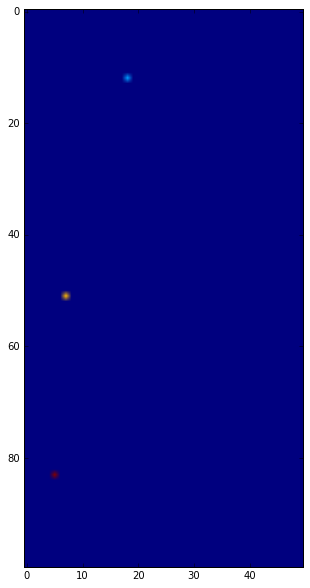

In [182]:
plt.figure(figsize=(5, 20))
plt.imshow(ifr[2600:2700, :50])

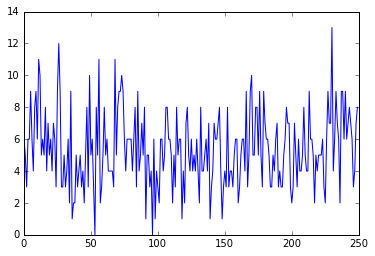

In [199]:
plt.plot(np.sum(np.reshape(input_t_dvs, (-1, T2)), axis=0))